In [1]:
!pip install koreanize-matplotlib

In [2]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import koreanize_matplotlib

%matplotlib inline

In [3]:
import os
import shutil
import sys
import urllib.request
import json
import pandas as pd
import re
import joblib

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models.vgg import vgg19
import numpy as np
import time

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ResNet의 평균 표준편차
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ResNet의 평균 표준편차
])

In [7]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

In [8]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 64, shuffle = True)

In [9]:
print(len(train_datasets))
print(len(test_datasets))

4013
969


In [10]:
class_names = train_datasets.classes
print('클래스: ', class_names)

클래스:  ['bar chair', 'bean bag sofa', 'chesterfield sofa', 'dining chair', 'folding chair', 'gaming chair', 'lounge sofa', 'module sofa', 'office_chair', 'recliner sofa', 'round stool chair']


In [11]:
# model_v2 : batch size 64, lr 1e-4, 전이학습 모델 ResNet
model_v2 = models.resnet34(pretrained = True)

In [12]:
for param in model_v2.parameters():
    param.requires_grad = False

In [13]:
fc_input_features = model_v2.fc.in_features
fc_input_features

512

In [14]:
model_v2.fc = nn.Linear(fc_input_features, 11)

for name, module in model_v2.named_parameters():
    print(name, module.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer2.2.conv1.weight False
layer2.2.bn1.weight False
layer2.2.bn1

In [15]:
import tqdm

lr = 1e-4
optimizer_v2 = optim.Adam(model_v2.parameters(), lr = lr)
model_v2.to(device)
start_time = time.time()

for epoch in range(50):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v2.zero_grad()
        preds = model_v2(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v2.step()

    print(f'epoch: {epoch+1}, loss: {loss.item()}, time: {time.time() - start_time}')
    
torch.save(model_v2.state_dict(), 'model_v2_ResNet.pth')

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:37<00:00,  1.66it/s]


epoch: 1, loss: 2.1657543182373047, time: 37.976956367492676


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:17<00:00,  3.60it/s]


epoch: 2, loss: 1.7958722114562988, time: 55.46309804916382


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.37it/s]


epoch: 3, loss: 1.670481562614441, time: 74.15178060531616


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.37it/s]


epoch: 4, loss: 1.4554660320281982, time: 92.82608318328857


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.32it/s]


epoch: 5, loss: 1.3051433563232422, time: 111.79143905639648


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.33it/s]


epoch: 6, loss: 1.1794999837875366, time: 130.69733786582947


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.38it/s]


epoch: 7, loss: 1.1410075426101685, time: 149.32467532157898


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.27it/s]


epoch: 8, loss: 1.134469747543335, time: 168.59215688705444


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.30it/s]


epoch: 9, loss: 0.9907065629959106, time: 187.71068048477173


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.27it/s]


epoch: 10, loss: 1.1220941543579102, time: 206.98098874092102


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.25it/s]


epoch: 11, loss: 0.8500618934631348, time: 226.39731097221375


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.22it/s]


epoch: 12, loss: 0.9009194374084473, time: 245.9887466430664


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.26it/s]


epoch: 13, loss: 0.9880372881889343, time: 265.3015966415405


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.23it/s]


epoch: 14, loss: 0.7774550318717957, time: 284.8068552017212


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.29it/s]


epoch: 15, loss: 0.810215175151825, time: 303.95869636535645


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.33it/s]


epoch: 16, loss: 0.9072115421295166, time: 322.89794182777405


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.41it/s]


epoch: 17, loss: 0.6459513902664185, time: 341.4021472930908


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.35it/s]


epoch: 18, loss: 0.7003657221794128, time: 360.19677996635437


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.29it/s]


epoch: 19, loss: 0.7928635478019714, time: 379.34491205215454


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.30it/s]


epoch: 20, loss: 0.8981319069862366, time: 398.4415211677551


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.28it/s]


epoch: 21, loss: 0.7933818101882935, time: 417.67394828796387


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.35it/s]


epoch: 22, loss: 0.6558835506439209, time: 436.48099875450134


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.34it/s]


epoch: 23, loss: 0.800818145275116, time: 455.3606450557709


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.20it/s]


epoch: 24, loss: 0.781070351600647, time: 475.0548207759857


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.28it/s]


epoch: 25, loss: 0.573230504989624, time: 494.2418029308319


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.25it/s]


epoch: 26, loss: 0.9132124781608582, time: 513.6158967018127


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.33it/s]


epoch: 27, loss: 0.555866003036499, time: 532.5611245632172


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.29it/s]


epoch: 28, loss: 0.7597728967666626, time: 551.6936492919922


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.23it/s]


epoch: 29, loss: 0.5358038544654846, time: 571.2132294178009


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.24it/s]


epoch: 30, loss: 0.7748820781707764, time: 590.6501753330231


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.25it/s]


epoch: 31, loss: 0.5864130258560181, time: 610.0176808834076


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.30it/s]


epoch: 32, loss: 0.608073890209198, time: 629.1291599273682


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.34it/s]


epoch: 33, loss: 0.5767631530761719, time: 648.0310425758362


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.29it/s]


epoch: 34, loss: 0.5579422116279602, time: 667.1520915031433


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.30it/s]


epoch: 35, loss: 0.5401342511177063, time: 686.2468037605286


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.30it/s]


epoch: 36, loss: 0.6220520734786987, time: 705.3233020305634


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.36it/s]


epoch: 37, loss: 0.41339483857154846, time: 724.0713913440704


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.27it/s]


epoch: 38, loss: 0.5415581464767456, time: 743.3367352485657


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.31it/s]


epoch: 39, loss: 0.7680936455726624, time: 762.3484954833984


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.31it/s]


epoch: 40, loss: 0.4964677095413208, time: 781.3758096694946


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.25it/s]


epoch: 41, loss: 0.6063473224639893, time: 800.7482254505157


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.25it/s]


epoch: 42, loss: 0.8325716853141785, time: 820.1678380966187


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.25it/s]


epoch: 43, loss: 0.5580845475196838, time: 839.5474355220795


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.16it/s]


epoch: 44, loss: 0.515891969203949, time: 859.4727129936218


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.20it/s]


epoch: 45, loss: 0.5225232839584351, time: 879.1592013835907


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.26it/s]


epoch: 46, loss: 0.5942273736000061, time: 898.4790608882904


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.33it/s]


epoch: 47, loss: 0.5168982744216919, time: 917.3919610977173


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.29it/s]


epoch: 48, loss: 0.5654012560844421, time: 936.5606799125671


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.22it/s]


epoch: 49, loss: 0.5771635174751282, time: 956.132794380188


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:19<00:00,  3.18it/s]

epoch: 50, loss: 0.6959288120269775, time: 975.9384243488312


In [16]:
# model_v2 정확도 0.7277
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v2(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7275541795665634


In [17]:
# model_v3 : batch size 32, lr 3e-4, 전이학습 모델 ResNet
model_v3 = models.resnet34(pretrained = True)

In [18]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

In [19]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = True)

In [20]:
for param in model_v3.parameters():
    param.requires_grad = False
    
fc_input_features = model_v3.fc.in_features
model_v3.fc = nn.Linear(fc_input_features, 11)

In [21]:
import tqdm

lr = 3e-4
optimizer_v3 = optim.Adam(model_v3.parameters(), lr = lr)
model_v3.to(device)
start_time = time.time()

for epoch in range(50):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v3.zero_grad()
        preds = model_v3(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v3.step()

    print(f'epoch: {epoch+1}, loss: {loss.item()}, time: {time.time() - start_time}')
    
torch.save(model_v3.state_dict(), 'model_v3_ResNet.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.62it/s]


epoch: 1, loss: 1.3989735841751099, time: 19.019782781600952


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.69it/s]


epoch: 2, loss: 0.7843872904777527, time: 37.85287547111511


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.69it/s]


epoch: 3, loss: 0.868108868598938, time: 56.69223999977112


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.74it/s]


epoch: 4, loss: 0.804140031337738, time: 75.40697836875916


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.61it/s]


epoch: 5, loss: 0.6246197819709778, time: 94.46354484558105


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.65it/s]


epoch: 6, loss: 0.6960545778274536, time: 113.40560865402222


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.57it/s]


epoch: 7, loss: 0.6314722299575806, time: 132.60214734077454


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.65it/s]


epoch: 8, loss: 0.6851866841316223, time: 151.56530261039734


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.65it/s]


epoch: 9, loss: 0.564052939414978, time: 170.50957942008972


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.73it/s]


epoch: 10, loss: 0.6053895950317383, time: 189.24331521987915


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.74it/s]


epoch: 11, loss: 0.716842770576477, time: 207.95300793647766


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.60it/s]


epoch: 12, loss: 0.286970317363739, time: 227.04864168167114


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.67it/s]


epoch: 13, loss: 0.5035186409950256, time: 245.95800614356995


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.53it/s]


epoch: 14, loss: 0.24874700605869293, time: 265.27047753334045


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.42it/s]


epoch: 15, loss: 0.5982334613800049, time: 284.9018325805664


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.72it/s]


epoch: 16, loss: 0.6410828232765198, time: 303.642516374588


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.70it/s]


epoch: 17, loss: 0.6792532205581665, time: 322.4545238018036


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.67it/s]


epoch: 18, loss: 0.5031936168670654, time: 341.3355495929718


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.68it/s]


epoch: 19, loss: 0.4014813005924225, time: 360.20855617523193


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.63it/s]


epoch: 20, loss: 0.40097931027412415, time: 379.22449254989624


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.73it/s]


epoch: 21, loss: 0.32850468158721924, time: 397.93908429145813


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.66it/s]


epoch: 22, loss: 0.6797713041305542, time: 416.86225390434265


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.71it/s]


epoch: 23, loss: 0.414939820766449, time: 435.6328270435333


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.63it/s]


epoch: 24, loss: 0.14821235835552216, time: 454.6353943347931


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.73it/s]


epoch: 25, loss: 0.5558683276176453, time: 473.3732581138611


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.58it/s]


epoch: 26, loss: 0.3128957748413086, time: 492.51717233657837


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.58it/s]


epoch: 27, loss: 0.27250826358795166, time: 511.68836760520935


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.58it/s]


epoch: 28, loss: 0.520263135433197, time: 530.8488028049469


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.65it/s]


epoch: 29, loss: 0.4620421826839447, time: 549.8081459999084


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.64it/s]


epoch: 30, loss: 0.7285842299461365, time: 568.7940988540649


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.55it/s]


epoch: 31, loss: 0.3161897361278534, time: 588.0219266414642


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.58it/s]


epoch: 32, loss: 0.14274509251117706, time: 607.1630821228027


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.38it/s]


epoch: 33, loss: 0.3652547299861908, time: 626.913516998291


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.68it/s]


epoch: 34, loss: 0.28773605823516846, time: 645.7706942558289


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.60it/s]


epoch: 35, loss: 0.9481042623519897, time: 664.8581938743591


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.54it/s]


epoch: 36, loss: 0.5813645124435425, time: 684.1345829963684


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.66it/s]


epoch: 37, loss: 0.5214259624481201, time: 703.054271697998


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.45it/s]


epoch: 38, loss: 0.42980891466140747, time: 722.574303150177


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.43it/s]


epoch: 39, loss: 0.44355615973472595, time: 742.1659140586853


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.60it/s]


epoch: 40, loss: 0.6397221684455872, time: 761.2529141902924


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.61it/s]


epoch: 41, loss: 0.6247959733009338, time: 780.3439102172852


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.43it/s]


epoch: 42, loss: 0.6008889079093933, time: 799.9681632518768


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.41it/s]


epoch: 43, loss: 0.2898515462875366, time: 819.6120355129242


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:20<00:00,  6.27it/s]


epoch: 44, loss: 0.6147398948669434, time: 839.736807346344


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:20<00:00,  6.28it/s]


epoch: 45, loss: 0.866938591003418, time: 859.7928831577301


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.40it/s]


epoch: 46, loss: 0.18109747767448425, time: 879.484349489212


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.40it/s]


epoch: 47, loss: 0.150709331035614, time: 899.1859843730927


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:20<00:00,  6.29it/s]


epoch: 48, loss: 0.3974183201789856, time: 919.2407126426697


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.41it/s]


epoch: 49, loss: 0.6663717031478882, time: 938.9106657505035


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.42it/s]


epoch: 50, loss: 0.5577552318572998, time: 958.5406212806702


In [22]:
# model_v3(batch size 32, lr 3e-4, 전이학습 모델 ResNet) 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v3(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7316821465428277


In [23]:
# model_v4 : batch size 32, lr 3e-5, 전이학습 모델 ResNet
model_v4 = models.resnet34(pretrained = True)

In [24]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

In [25]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = True)

In [26]:
for param in model_v4.parameters():
    param.requires_grad = False
    
fc_input_features = model_v4.fc.in_features
model_v4.fc = nn.Linear(fc_input_features, 11)

In [27]:
import tqdm

lr = 3e-5
optimizer_v4 = optim.Adam(model_v4.parameters(), lr = lr)
model_v4.to(device)
start_time = time.time()

for epoch in range(50):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v4.zero_grad()
        preds = model_v4(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v4.step()

    print(f'epoch: {epoch+1}, loss: {loss.item()}, time: {time.time() - start_time}')
    
torch.save(model_v4.state_dict(), 'model_v4_ResNet.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.56it/s]


epoch: 1, loss: 2.368546962738037, time: 19.211333513259888


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.73it/s]


epoch: 2, loss: 2.1317667961120605, time: 37.93894720077515


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.58it/s]


epoch: 3, loss: 1.8566035032272339, time: 57.08826494216919


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.68it/s]


epoch: 4, loss: 1.8955886363983154, time: 75.939448595047


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.54it/s]


epoch: 5, loss: 1.84873366355896, time: 95.19364500045776


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.47it/s]


epoch: 6, loss: 1.9165728092193604, time: 114.68592429161072


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.53it/s]


epoch: 7, loss: 1.8669641017913818, time: 133.98562788963318


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.67it/s]


epoch: 8, loss: 1.7738380432128906, time: 152.8691611289978


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.46it/s]


epoch: 9, loss: 1.7286051511764526, time: 172.37372136116028


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.64it/s]


epoch: 10, loss: 1.412400722503662, time: 191.359765291214


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.35it/s]


epoch: 11, loss: 1.3163559436798096, time: 211.2172815799713


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.61it/s]


epoch: 12, loss: 1.1286404132843018, time: 230.27389359474182


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.55it/s]


epoch: 13, loss: 1.2589949369430542, time: 249.50960183143616


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.62it/s]


epoch: 14, loss: 1.2035374641418457, time: 268.5438594818115


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.61it/s]


epoch: 15, loss: 1.2358237504959106, time: 287.6121597290039


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.51it/s]


epoch: 16, loss: 1.20093834400177, time: 306.9897491931915


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.60it/s]


epoch: 17, loss: 0.8139399290084839, time: 326.07527804374695


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.67it/s]


epoch: 18, loss: 1.4097167253494263, time: 344.9699273109436


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.54it/s]


epoch: 19, loss: 1.46792471408844, time: 364.24238443374634


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.45it/s]


epoch: 20, loss: 1.2817702293395996, time: 383.77186393737793


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.70it/s]


epoch: 21, loss: 0.9184352159500122, time: 402.59354853630066


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.70it/s]


epoch: 22, loss: 0.9740146398544312, time: 421.4186499118805


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.55it/s]


epoch: 23, loss: 1.3091235160827637, time: 440.67042350769043


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.60it/s]


epoch: 24, loss: 1.0437020063400269, time: 459.7665903568268


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.59it/s]


epoch: 25, loss: 0.8576002717018127, time: 478.90558314323425


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.66it/s]


epoch: 26, loss: 0.940700113773346, time: 497.8376693725586


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.57it/s]


epoch: 27, loss: 0.9244928359985352, time: 517.0242083072662


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.69it/s]


epoch: 28, loss: 1.5331761837005615, time: 535.8549461364746


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.65it/s]


epoch: 29, loss: 1.0027095079421997, time: 554.8029942512512


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.62it/s]


epoch: 30, loss: 0.799561619758606, time: 573.8485689163208


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.67it/s]


epoch: 31, loss: 0.811812162399292, time: 592.7530372142792


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.56it/s]


epoch: 32, loss: 0.848759114742279, time: 611.9494647979736


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.55it/s]


epoch: 33, loss: 1.0521377325057983, time: 631.2005231380463


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.62it/s]


epoch: 34, loss: 0.6698218584060669, time: 650.2382850646973


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.65it/s]


epoch: 35, loss: 1.0811469554901123, time: 669.1920418739319


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.75it/s]


epoch: 36, loss: 0.8574205636978149, time: 687.8755309581757


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.55it/s]


epoch: 37, loss: 0.5989853143692017, time: 707.1106164455414


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.54it/s]


epoch: 38, loss: 0.9111798405647278, time: 726.3915326595306


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.67it/s]


epoch: 39, loss: 0.6195927858352661, time: 745.2766304016113


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.62it/s]


epoch: 40, loss: 0.6908184885978699, time: 764.3337154388428


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.49it/s]


epoch: 41, loss: 1.0485098361968994, time: 783.742235660553


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:18<00:00,  6.66it/s]


epoch: 42, loss: 0.7515404224395752, time: 802.679979801178


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.52it/s]


epoch: 43, loss: 0.8341395854949951, time: 822.0252180099487


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.46it/s]


epoch: 44, loss: 1.2199523448944092, time: 841.5275564193726


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.32it/s]


epoch: 45, loss: 1.0843182802200317, time: 861.4677484035492


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.33it/s]


epoch: 46, loss: 0.998116135597229, time: 881.3641755580902


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:20<00:00,  6.23it/s]


epoch: 47, loss: 0.9723833799362183, time: 901.5830051898956


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:19<00:00,  6.41it/s]


epoch: 48, loss: 0.5659177303314209, time: 921.2501850128174


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:21<00:00,  5.96it/s]


epoch: 49, loss: 0.709499716758728, time: 942.3850164413452


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:20<00:00,  6.24it/s]


epoch: 50, loss: 0.43081778287887573, time: 962.5892634391785


In [28]:
# model_v4 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v4(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7100103199174407


In [20]:
from torchvision.models.vgg import vgg19

In [30]:
# model_v6 : batch size 32, lr 1e-4, 전이학습 모델 VGG19
model_v6 = vgg19(pretrained = True)

In [31]:
for param in model_v6.parameters():
    param.requires_grad = False

In [32]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

In [33]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = True)

In [34]:
model_v6.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [35]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

In [36]:
model_v6.classifier = fc
model_v6.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [37]:
import tqdm

lr = 1e-4
optimizer_v6 = optim.Adam(model_v6.parameters(), lr = lr)
start_time = time.time()

for epoch in range(50):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v6.zero_grad()
        preds = model_v6(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v6.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')

torch.save(model_v6.state_dict(), 'model_v6_vgg19.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:37<00:00,  3.39it/s]


epoch: 1, loss: 0.6917480826377869


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.53it/s]


epoch: 2, loss: 0.42974668741226196


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.54it/s]


epoch: 3, loss: 0.04744990915060043


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.47it/s]


epoch: 4, loss: 0.07088767737150192


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.48it/s]


epoch: 5, loss: 0.19043898582458496


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.47it/s]


epoch: 6, loss: 0.3875426948070526


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.55it/s]


epoch: 7, loss: 0.11883994936943054


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.49it/s]


epoch: 8, loss: 0.017263250425457954


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.48it/s]


epoch: 9, loss: 0.039510056376457214


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.51it/s]


epoch: 10, loss: 0.0022356132976710796


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.47it/s]


epoch: 11, loss: 0.013878201134502888


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.55it/s]


epoch: 12, loss: 0.052177127450704575


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.49it/s]


epoch: 13, loss: 0.029391266405582428


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.45it/s]


epoch: 14, loss: 0.004088329151272774


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.44it/s]


epoch: 15, loss: 0.00020643632160499692


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.53it/s]


epoch: 16, loss: 0.0016246269224211574


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.49it/s]


epoch: 17, loss: 8.792931475909427e-05


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:37<00:00,  3.38it/s]


epoch: 18, loss: 0.000289260467980057


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.44it/s]


epoch: 19, loss: 0.0007412568083964288


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.50it/s]


epoch: 20, loss: 0.0012774198548868299


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.54it/s]


epoch: 21, loss: 0.00016231850895565003


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.56it/s]


epoch: 22, loss: 0.001161355059593916


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 23, loss: 0.0011679489398375154


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.58it/s]


epoch: 24, loss: 0.0007741065346635878


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.56it/s]


epoch: 25, loss: 0.019946454092860222


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 26, loss: 0.03417670354247093


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.58it/s]


epoch: 27, loss: 0.00017659009608905762


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.59it/s]


epoch: 28, loss: 0.00037428989890031517


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.56it/s]


epoch: 29, loss: 0.00047301125596277416


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.59it/s]


epoch: 30, loss: 0.1676149219274521


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.46it/s]


epoch: 31, loss: 0.018427331000566483


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.44it/s]


epoch: 32, loss: 0.0009877720149233937


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.48it/s]


epoch: 33, loss: 0.11573994159698486


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.51it/s]


epoch: 34, loss: 0.0063593205995857716


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.50it/s]


epoch: 35, loss: 0.030820060521364212


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.47it/s]


epoch: 36, loss: 0.3102378845214844


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.53it/s]


epoch: 37, loss: 0.002137097530066967


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 38, loss: 1.4121337699180003e-05


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.56it/s]


epoch: 39, loss: 0.0001694596721790731


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 40, loss: 0.0012152186827734113


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 41, loss: 0.0021922027226537466


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.56it/s]


epoch: 42, loss: 0.0034912372939288616


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.59it/s]


epoch: 43, loss: 0.0009093645494431257


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.58it/s]


epoch: 44, loss: 3.787142986766412e-06


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 45, loss: 0.00020842347294092178


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.56it/s]


epoch: 46, loss: 0.002752633998170495


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 47, loss: 0.0002613311226014048


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 48, loss: 0.00048576563131064177


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 49, loss: 0.002377955475822091


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 50, loss: 2.33249429584248e-05


In [38]:
# model_v6 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v6(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7440660474716202


In [39]:
# model_v8 : batch size 32, lr 1e-5, 전이학습 모델 VGG19
model_v8 = vgg19(pretrained = True)

In [40]:
for param in model_v8.parameters():
    param.requires_grad = False

In [41]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

In [42]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = True)

In [43]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

model_v8.classifier = fc
model_v8.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [44]:
import tqdm

lr = 1e-5
optimizer_v8 = optim.Adam(model_v8.parameters(), lr = lr)
start_time = time.time()

for epoch in range(50):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v8.zero_grad()
        preds = model_v8(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v8.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')

torch.save(model_v8.state_dict(), 'model_v8_vgg19.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.45it/s]


epoch: 1, loss: 1.0221240520477295


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.55it/s]


epoch: 2, loss: 0.8031551837921143


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.56it/s]


epoch: 3, loss: 0.5485885739326477


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.55it/s]


epoch: 4, loss: 0.3047773540019989


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.53it/s]


epoch: 5, loss: 0.5461555123329163


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.54it/s]


epoch: 6, loss: 0.22032935917377472


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.52it/s]


epoch: 7, loss: 0.18495114147663116


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.58it/s]


epoch: 8, loss: 0.13164816796779633


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.58it/s]


epoch: 9, loss: 0.07717429846525192


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 10, loss: 0.04847600311040878


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.54it/s]


epoch: 11, loss: 0.014299258589744568


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.56it/s]


epoch: 12, loss: 0.03639616444706917


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.54it/s]


epoch: 13, loss: 0.22436562180519104


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.55it/s]


epoch: 14, loss: 0.12956571578979492


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 15, loss: 0.024910183623433113


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.58it/s]


epoch: 16, loss: 0.11348783224821091


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.58it/s]


epoch: 17, loss: 0.12045914679765701


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 18, loss: 0.0044513787142932415


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.47it/s]


epoch: 19, loss: 0.020372141152620316


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.52it/s]


epoch: 20, loss: 0.006880804896354675


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.61it/s]


epoch: 21, loss: 0.00836748257279396


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.59it/s]


epoch: 22, loss: 0.006621383596211672


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.59it/s]


epoch: 23, loss: 0.0020964450668543577


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 24, loss: 0.3164803683757782


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.58it/s]


epoch: 25, loss: 0.005876514595001936


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.60it/s]


epoch: 26, loss: 0.009529035538434982


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.60it/s]


epoch: 27, loss: 0.00920963380485773


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.60it/s]


epoch: 28, loss: 0.0060753729194402695


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.54it/s]


epoch: 29, loss: 0.004448362626135349


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 30, loss: 0.11370499432086945


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 31, loss: 0.0038026829715818167


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 32, loss: 0.0018372711492702365


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.56it/s]


epoch: 33, loss: 0.008843549527227879


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.55it/s]


epoch: 34, loss: 0.0022630926687270403


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 35, loss: 0.01763511821627617


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.58it/s]


epoch: 36, loss: 0.0317421518266201


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.56it/s]


epoch: 37, loss: 0.0027897758409380913


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.59it/s]


epoch: 38, loss: 0.0029925787821412086


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.59it/s]


epoch: 39, loss: 0.0010278746485710144


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.60it/s]


epoch: 40, loss: 0.011556845158338547


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 41, loss: 0.0011324940714985132


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.60it/s]


epoch: 42, loss: 0.001566368038766086


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 43, loss: 0.0031808307394385338


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.59it/s]


epoch: 44, loss: 0.005089667160063982


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.54it/s]


epoch: 45, loss: 0.0002949572808574885


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.53it/s]


epoch: 46, loss: 0.009520065039396286


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.51it/s]


epoch: 47, loss: 0.002949562156572938


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.55it/s]


epoch: 48, loss: 0.00543350912630558


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.58it/s]


epoch: 49, loss: 0.009331007488071918


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.57it/s]


epoch: 50, loss: 0.0005635764682665467


In [45]:
# model_v8 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v8(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7708978328173375


In [11]:
from torchvision.models.vgg import vgg16

In [12]:
# model_v9 : batch size 32, lr 1e-5, 전이학습 모델 VGG16
model_v9 = vgg16(pretrained = True)

In [13]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

In [14]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = False)

In [15]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

model_v9.classifier = fc
model_v9.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
import tqdm

lr = 1e-5
optimizer_v9 = optim.Adam(model_v9.parameters(), lr = lr)
start_time = time.time()

for epoch in range(50):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v9.zero_grad()
        preds = model_v9(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v9.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')

torch.save(model_v9.state_dict(), 'model_v9_vgg16.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:58<00:00,  2.16it/s]


epoch: 1, loss: 1.0275722742080688


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.29it/s]


epoch: 2, loss: 0.2320461869239807


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 3, loss: 0.9640096426010132


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 4, loss: 0.23852196335792542


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.28it/s]


epoch: 5, loss: 0.26981809735298157


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 6, loss: 0.026238510385155678


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.28it/s]


epoch: 7, loss: 0.003903900505974889


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.25it/s]


epoch: 8, loss: 0.010442057624459267


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 9, loss: 0.11011861264705658


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:58<00:00,  2.15it/s]


epoch: 10, loss: 0.0397181361913681


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:00<00:00,  2.10it/s]


epoch: 11, loss: 0.0004960452788509429


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.25it/s]


epoch: 12, loss: 0.1125158816576004


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.28it/s]


epoch: 13, loss: 0.028144674375653267


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 14, loss: 0.030000116676092148


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 15, loss: 0.28465545177459717


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 16, loss: 0.011393098160624504


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 17, loss: 0.004341762978583574


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.24it/s]


epoch: 18, loss: 0.008641091175377369


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:58<00:00,  2.15it/s]


epoch: 19, loss: 0.012984493747353554


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:58<00:00,  2.16it/s]


epoch: 20, loss: 0.0014761972706764936


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:00<00:00,  2.10it/s]


epoch: 21, loss: 0.0003931074170395732


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.25it/s]


epoch: 22, loss: 0.0031099228654056787


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.23it/s]


epoch: 23, loss: 0.0007848929963074625


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 24, loss: 0.005297600291669369


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.25it/s]


epoch: 25, loss: 0.0015528363874182105


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.24it/s]


epoch: 26, loss: 0.046156030148267746


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.25it/s]


epoch: 27, loss: 0.0005811847513541579


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.25it/s]


epoch: 28, loss: 0.1125514805316925


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 29, loss: 0.0020492475014179945


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 30, loss: 0.0004841886111535132


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 31, loss: 8.648799848742783e-05


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 32, loss: 0.006677193101495504


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.24it/s]


epoch: 33, loss: 0.0021352791227400303


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 34, loss: 0.0009277929784730077


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.25it/s]


epoch: 35, loss: 0.02042117342352867


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.21it/s]


epoch: 36, loss: 0.004387775436043739


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.25it/s]


epoch: 37, loss: 0.0014062406262382865


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 38, loss: 0.01438253652304411


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 39, loss: 0.0004422444326337427


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 40, loss: 0.0004157598305027932


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 41, loss: 0.0006718825898133218


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 42, loss: 0.0024942958261817694


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 43, loss: 0.0022556697949767113


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 44, loss: 3.7328238249756396e-05


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:56<00:00,  2.25it/s]


epoch: 45, loss: 0.0007071652798913419


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 46, loss: 7.979931979207322e-05


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 47, loss: 0.00020098623645026237


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 48, loss: 0.0010691240895539522


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.26it/s]


epoch: 49, loss: 0.0005884660640731454


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:55<00:00,  2.27it/s]


epoch: 50, loss: 0.013669333420693874


In [18]:
# model_v9(batch size 32, lr 1e-5, 전이학습 모델 VGG16) 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v9(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7678018575851393


In [8]:
from torchvision.models.vgg import vgg19

In [9]:
# model_v10 : batch size 32, lr 3e-5, 전이학습 모델 VGG19
model_v10 = vgg19(pretrained = True)

In [10]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

In [11]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = False)

In [12]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

model_v10.classifier = fc
model_v10.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [13]:
import tqdm

lr = 3e-5
optimizer_v10 = optim.Adam(model_v10.parameters(), lr = lr)
start_time = time.time()

for epoch in range(30):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v10.zero_grad()
        preds = model_v10(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v10.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')

torch.save(model_v10.state_dict(), 'model_v10_vgg19.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:06<00:00,  1.90it/s]


epoch: 1, loss: 0.22524479031562805


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 2, loss: 0.6409888863563538


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  2.00it/s]


epoch: 3, loss: 0.10910645872354507


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 4, loss: 0.2889065444469452


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 5, loss: 0.44204047322273254


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 6, loss: 0.15617990493774414


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 7, loss: 0.0007638987153768539


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  2.00it/s]


epoch: 8, loss: 0.007581320125609636


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 9, loss: 0.0012339323293417692


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 10, loss: 0.43732041120529175


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 11, loss: 0.03426838293671608


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 12, loss: 0.00037599095958285034


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 13, loss: 0.008654759265482426


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.99it/s]


epoch: 14, loss: 0.003932061139494181


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:27<00:00,  1.45it/s]


epoch: 15, loss: 0.0023782039061188698


  1%|▋                                                                                 | 1/126 [00:01<02:59,  1.43s/it]


KeyboardInterrupt: 

In [14]:
# model_v10 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v10(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7987616099071208


In [15]:
torch.save(model_v10.state_dict(), 'model_v10_vgg19.pth')

In [6]:
from torchvision.models.vgg import vgg19

In [7]:
# model_v11 : batch size 32, lr 5e-5, 전이학습 모델 VGG19, epoch 15
model_v11 = vgg19(pretrained = True)

In [11]:
for param in model_v11.parameters():
    param.requires_grad = False

In [12]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

In [13]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = False)

In [14]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

model_v11.classifier = fc
model_v11.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
import tqdm

lr = 5e-5
optimizer_v11 = optim.Adam(model_v11.parameters(), lr = lr)
start_time = time.time()

for epoch in range(15):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v11.zero_grad()
        preds = model_v11(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v11.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')

torch.save(model_v11.state_dict(), 'model_v11_vgg19.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:40<00:00,  3.10it/s]


epoch: 1, loss: 0.4479171335697174


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.80it/s]


epoch: 2, loss: 0.6237158179283142


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.77it/s]


epoch: 3, loss: 0.24583210051059723


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.77it/s]


epoch: 4, loss: 0.112447090446949


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.75it/s]


epoch: 5, loss: 0.018613301217556


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.75it/s]


epoch: 6, loss: 0.00461135758087039


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.73it/s]


epoch: 7, loss: 0.006013308186084032


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.72it/s]


epoch: 8, loss: 0.03483898565173149


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.72it/s]


epoch: 9, loss: 0.0026549932081252337


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.72it/s]


epoch: 10, loss: 0.048637911677360535


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.71it/s]


epoch: 11, loss: 0.03409218415617943


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:09<00:00,  1.82it/s]


epoch: 12, loss: 0.003308482002466917


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.73it/s]


epoch: 13, loss: 0.01373332180082798


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.73it/s]


epoch: 14, loss: 0.007312704809010029


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.73it/s]


epoch: 15, loss: 0.0031395552214235067


In [16]:
# model_v11 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v11(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.759545923632611


In [18]:
# model_v12 : batch size 32, lr 3e-5, 전이학습 모델 VGG19, epoch 15, 얼리는 범위 조절
model_v12 = vgg19(pretrained = True)

In [22]:
for param in model_v12.parameters():
    param.requires_grad = False
    
for param in model_v12.features[-4:].parameters():
    param.requires_grad = True

In [23]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

model_v12.classifier = fc
model_v12.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [27]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

In [28]:
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = False)

In [29]:
import tqdm

lr = 3e-5
optimizer_v12 = optim.Adam(model_v12.parameters(), lr = lr)
start_time = time.time()

for epoch in range(15):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v12.zero_grad()
        preds = model_v12(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v12.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')

torch.save(model_v12.state_dict(), 'model_v12_vgg19.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:10<00:00,  1.51s/it]


epoch: 1, loss: 0.68083256483078


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:05<00:00,  1.47s/it]


epoch: 2, loss: 0.262920081615448


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:05<00:00,  1.47s/it]


epoch: 3, loss: 0.6955090761184692


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:05<00:00,  1.47s/it]


epoch: 4, loss: 0.023304106667637825


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:05<00:00,  1.47s/it]


epoch: 5, loss: 0.02711455710232258


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:05<00:00,  1.47s/it]


epoch: 6, loss: 0.21957936882972717


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:04<00:00,  1.47s/it]


epoch: 7, loss: 0.012486334890127182


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:04<00:00,  1.46s/it]


epoch: 8, loss: 0.0055752103216946125


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:04<00:00,  1.46s/it]


epoch: 9, loss: 0.0025270183105021715


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:04<00:00,  1.46s/it]


epoch: 10, loss: 0.0431879386305809


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:04<00:00,  1.46s/it]


epoch: 11, loss: 0.005860301200300455


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [03:04<00:00,  1.46s/it]


epoch: 12, loss: 0.01785135641694069


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:20<00:00,  1.57it/s]


epoch: 13, loss: 0.002467099344357848


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.72it/s]


epoch: 14, loss: 0.012761685997247696


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.69it/s]


epoch: 15, loss: 0.0005509206675924361


In [30]:
# model_v12 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v12(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7832817337461301


In [31]:
# model_v13 : batch size 32, lr 1e-5, 전이학습 모델 VGG19, epoch 15, 얼리는 범위 조절
model_v13 = vgg19(pretrained = True)

for param in model_v13.parameters():
    param.requires_grad = False
    
for param in model_v13.features[-4:].parameters():
    param.requires_grad = True

In [37]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

model_v13.classifier = fc
model_v13.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [38]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = False)

In [39]:
import tqdm

lr = 1e-4
optimizer_v13 = optim.Adam(model_v13.parameters(), lr = lr)
start_time = time.time()

for epoch in range(15):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v13.zero_grad()
        preds = model_v13(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v13.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')

torch.save(model_v13.state_dict(), 'model_v13_vgg19.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.70it/s]


epoch: 1, loss: 0.12149509787559509


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.65it/s]


epoch: 2, loss: 0.30185213685035706


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.67it/s]


epoch: 3, loss: 0.23275600373744965


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.66it/s]


epoch: 4, loss: 0.000811646634247154


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.66it/s]


epoch: 5, loss: 0.003294359426945448


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:05<00:00,  1.91it/s]


epoch: 6, loss: 0.9139891862869263


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.70it/s]


epoch: 7, loss: 0.07615531235933304


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.68it/s]


epoch: 8, loss: 0.005960304755717516


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.67it/s]


epoch: 9, loss: 0.002235615160316229


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:07<00:00,  1.86it/s]


epoch: 10, loss: 0.00014560905401594937


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.71it/s]


epoch: 11, loss: 0.002564724301919341


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.68it/s]


epoch: 12, loss: 0.02874305099248886


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.66it/s]


epoch: 13, loss: 0.0012145257787778974


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:09<00:00,  1.81it/s]


epoch: 14, loss: 0.15571075677871704


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.68it/s]


epoch: 15, loss: 0.00015795660146977752


In [40]:
# model_v13 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v13(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7853457172342622


In [6]:
# model_v14 : batch size 32, lr 1e-5, 전이학습 모델 VGG19, epoch 15, 얼리는 범위 조절
model_v14 = vgg19(pretrained = True)

for param in model_v14.parameters():
    param.requires_grad = False
    
for param in model_v14.features[-8:].parameters():
    param.requires_grad = True

In [7]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

model_v14.classifier = fc
model_v14.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = False)

In [11]:
import tqdm

lr = 3e-5
optimizer_v14 = optim.Adam(model_v14.parameters(), lr = lr)
start_time = time.time()

for epoch in range(15):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v14.zero_grad()
        preds = model_v14(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v14.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')

torch.save(model_v14.state_dict(), 'model_v14_vgg19.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.71it/s]


epoch: 1, loss: 0.0006776284426450729


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.70it/s]


epoch: 2, loss: 0.0


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.68it/s]


epoch: 3, loss: 0.01860448531806469


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:07<00:00,  1.86it/s]


epoch: 4, loss: 0.0011125202290713787


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.71it/s]


epoch: 5, loss: 0.00014960888074710965


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.70it/s]


epoch: 6, loss: 0.0004133770999033004


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.68it/s]


epoch: 7, loss: 7.976572669576854e-05


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:16<00:00,  1.64it/s]


epoch: 8, loss: 7.803238077030983e-06


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.62it/s]


epoch: 9, loss: 4.144092235947028e-05


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.69it/s]


epoch: 10, loss: 0.0


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:03<00:00,  1.97it/s]


epoch: 11, loss: 5.863828118890524e-05


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:45<00:00,  2.77it/s]


epoch: 12, loss: 0.00510708661749959


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.70it/s]


epoch: 13, loss: 1.3515397768060211e-05


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.68it/s]


epoch: 14, loss: 8.252948191511678e-08


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:17<00:00,  1.64it/s]


epoch: 15, loss: 4.7683644766038924e-07


In [12]:
# model_v14(batch size 32, lr 1e-5, 전이학습 모델 VGG19, epoch 15, 얼리는 범위 조절) 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v14(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7997936016511867


In [21]:
# model_v15 : batch size 32, lr 1e-5, 전이학습 모델 VGG19, epoch 15, 얼리는 범위 조절
model_v15 = vgg19(pretrained = True)

for param in model_v15.parameters():
    param.requires_grad = False
    
for param in model_v15.features[-9:].parameters():
    param.requires_grad = True

In [22]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

model_v15.classifier = fc
model_v15.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [23]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 16, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 16, shuffle = False)

In [24]:
import tqdm

lr = 3e-5
optimizer_v15 = optim.Adam(model_v15.parameters(), lr = lr)
start_time = time.time()

for epoch in range(15):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v15.zero_grad()
        preds = model_v15(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v15.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')

torch.save(model_v15.state_dict(), 'model_v15_vgg19.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.97it/s]


epoch: 1, loss: 0.7696770429611206


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.90it/s]


epoch: 2, loss: 0.23890747129917145


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.88it/s]


epoch: 3, loss: 0.4482268691062927


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.87it/s]


epoch: 4, loss: 0.14137420058250427


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.83it/s]


epoch: 5, loss: 0.01004521083086729


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.87it/s]


epoch: 6, loss: 0.014774976298213005


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:37<00:00,  6.73it/s]


epoch: 7, loss: 0.056767787784338


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.81it/s]


epoch: 8, loss: 0.009105800651013851


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [01:13<00:00,  3.41it/s]


epoch: 9, loss: 0.050290122628211975


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.89it/s]


epoch: 10, loss: 0.0037434720434248447


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.84it/s]


epoch: 11, loss: 0.002310781739652157


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.82it/s]


epoch: 12, loss: 0.0009005538304336369


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [01:12<00:00,  3.47it/s]


epoch: 13, loss: 0.020360322669148445


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.88it/s]


epoch: 14, loss: 0.05795995146036148


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:36<00:00,  6.88it/s]


epoch: 15, loss: 0.0019130924483761191


In [25]:
# model_v15 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v15(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.782249742002064


In [6]:
# model_v16 : batch size 32, lr 1e-5, 전이학습 모델 VGG19, epoch 15, 얼리는 범위 조절
model_v16 = vgg19(pretrained = True)

for param in model_v16.parameters():
    param.requires_grad = False
    
for param in model_v16.features[-7:].parameters():
    param.requires_grad = True

In [7]:
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

model_v16.classifier = fc
model_v16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = False)

In [9]:
import tqdm

lr = 3e-5
optimizer_v16 = optim.Adam(model_v16.parameters(), lr = lr)
start_time = time.time()

for epoch in range(15):
    for data, label in tqdm.tqdm(train_loader):
        optimizer_v16.zero_grad()
        preds = model_v16(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer_v16.step()

    print(f'epoch: {epoch + 1}, loss: {loss.item()}')

torch.save(model_v16.state_dict(), 'model_v16_vgg19.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:37<00:00,  3.36it/s]


epoch: 1, loss: 0.7152099013328552


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.73it/s]


epoch: 2, loss: 0.8229446411132812


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.71it/s]


epoch: 3, loss: 0.3402840793132782


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.71it/s]


epoch: 4, loss: 0.4711233973503113


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.69it/s]


epoch: 5, loss: 0.040251877158880234


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.69it/s]


epoch: 6, loss: 0.04551129788160324


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.68it/s]


epoch: 7, loss: 0.06162766367197037


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.68it/s]


epoch: 8, loss: 0.018507082015275955


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.68it/s]


epoch: 9, loss: 0.0050544459372758865


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:05<00:00,  1.92it/s]


epoch: 10, loss: 0.430049866437912


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.72it/s]


epoch: 11, loss: 0.005143068265169859


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.69it/s]


epoch: 12, loss: 0.0028469508979469538


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:34<00:00,  3.67it/s]


epoch: 13, loss: 0.00115469959564507


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [01:04<00:00,  1.94it/s]


epoch: 14, loss: 0.008425307460129261


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:33<00:00,  3.71it/s]


epoch: 15, loss: 0.0008281585178337991


In [10]:
# model_v16 정확도 
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model_v16(images)
        _, pred = torch.max(preds.data, 1)

        total_corr += (pred == labels).sum().item()

    print(f'Acc {total_corr / len(test_datasets.targets)}')

Acc 0.7956656346749226


In [9]:
model_v14 = vgg19(pretrained = True)

for param in model_v14.parameters():
    param.requires_grad = False
    
for param in model_v14.features[-8:].parameters():
    param.requires_grad = True
    
fc = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 11)
)

model_v14.classifier = fc
model_v14.to(device)

model_v14.load_state_dict(torch.load('model_v14_vgg19.pth'))
model_v14.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
train_datasets = datasets.ImageFolder('./chair_dataset/train', transform_train)
test_datasets = datasets.ImageFolder('./chair_dataset/test', transform_test)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size = 32, shuffle = False)

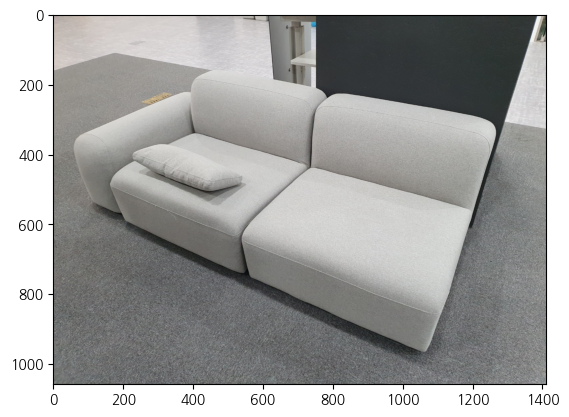

In [11]:
image = Image.open('모듈 소파.jpg')
plt.imshow(image)

In [12]:
img = transform_test(image)
img = img.reshape(-1, 3, 224, 224)

In [13]:
model_v14(img.to(device))

tensor([[ -8.3745,  -6.0758,  -5.7016,  -8.1799, -10.5085,  -9.2209,   1.8773,
          10.6642, -12.6930,   0.6896,  -3.8145]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [47]:
class_names = train_datasets.classes
print('클래스: ', class_names)

클래스:  ['bar chair', 'bean bag sofa', 'chesterfield sofa', 'dining chair', 'folding chair', 'gaming chair', 'lounge sofa', 'module sofa', 'office_chair', 'recliner sofa', 'round stool chair']


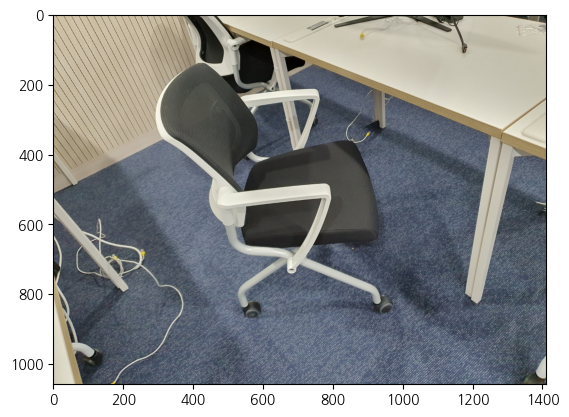

In [48]:
image = Image.open('사무용 의자.jpg')
plt.imshow(image)

In [49]:
img = transform_test(image)
img = img.reshape(-1, 3, 224, 224)

In [50]:
model_v14(img.to(device))

tensor([[-5.9783, -6.1313, -8.0725, -4.0297,  4.5628, -0.2958,  2.2496, -7.1702,
         -3.6479, -7.2118, -2.5654]], device='cuda:0', grad_fn=<AddmmBackward>)

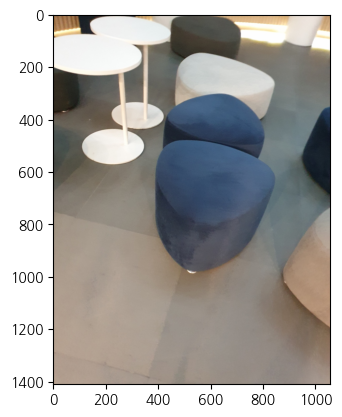

In [51]:
image = Image.open('원형 스툴 의자.jpg')
plt.imshow(image)

In [52]:
img = transform_test(image)
img = img.reshape(-1, 3, 224, 224)

In [53]:
model_v14(img.to(device))

tensor([[ -7.8677,  10.1437, -17.1841,  -5.5634, -13.4368,  -9.3759,  -3.5351,
         -10.1949, -19.5285, -11.8568,  -0.4230]], device='cuda:0',
       grad_fn=<AddmmBackward>)